# Import

In [25]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

from skimage.io import imread, imshow

from skimage import img_as_ubyte, img_as_float
from scipy.stats import norm

from IPython.display import clear_output
face_cascade = cv2.CascadeClassifier('C:\\Users\\swast\\Jupyter Codes\\models\\haarcascade_frontalface_default.xml')


In [26]:
face_cascade.empty()

False

# Save Frames From Video

In [27]:
c = int(input("Enter Webcam no: "))


capture=cv2.VideoCapture(c)

cod = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('out.avi',cod,20.0,(640,480))
f = 0
img = []
drtn = 0
while True:
    if(f == 0):
        time.sleep(2)
        start = time.time()
    ret,color_img =capture.read()
    cv2.imshow('Frames',color_img)

    gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_img)
    
    if(len(faces) >1):
        continue
        
    for (x,y,w,h) in faces:
        face_gray = gray_img[y:y+h, x:x+h]
        face_color = color_img[y:y+h, x:x+w]
        
        h = h//3 - 15
        x += 15
        w -= 38
        img = color_img[y:y+h,x:x+w]
    if(len(img) == 0):
        continue
    cv2.imshow('img',img)

    cv2.imwrite('Frame'+str(f)+'.jpg', img)
    f += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        drtn = (time.time() - start)
        break
        
capture.release()
cv2.destroyAllWindows()

Enter Webcam no: 1


In [202]:
f=2073
drtn=157
f//drtn

13

# Color Average

In [204]:
import os
bgr = np.zeros((f,4))
R = []
G = []
B = []
for k in range(f):
    img = cv2.imread('C:\\Users\\swast\\Jupyter Codes\\aditya3\\frame'+str(k)+'.jpg')  #Start from number 1
    print('frame'+str(k)+'.jpg')
    clear_output(wait=True)
#     try:
#         os.remove('C:\\Users\\swast\\Jupyter Codes\\frame'+str(k)+'.jpg')
#     except:
#         break
            
    h, w, c = img.shape #height, width, channnel

    #Initialize
    l=0
    b_ave=0; g_ave=0; r_ave=0

    rCh = img[:,:,0]
    gCh = img[:,:,1]
    bCh = img[:,:,2]
    
    R.append(np.mean(rCh))
    G.append(np.mean(gCh))
    B.append(np.mean(bCh))

frame1740.jpg


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Varience

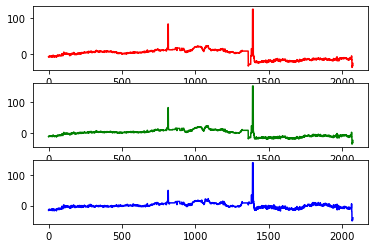

In [205]:

nR = (R - np.mean(R)) #/np.var(R)
nG = (G - np.mean(G)) #/np.var(G)
nB = (B - np.mean(B)) #/np.var(B)

plt.figure()
plt.subplot(3,1,1)
plt.plot(nR,color='red')
plt.subplot(3,1,2)
plt.plot(nG,color= 'Green')
plt.subplot(3,1,3)
plt.plot(nB, color='blue')

# Signal Detrend & Plot

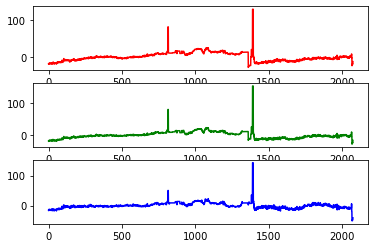

In [206]:
from scipy import signal

plt.figure()
plt.subplot(3,1,1)
plt.plot(signal.detrend(nR),color='red')
plt.subplot(3,1,2)
plt.plot(signal.detrend(nG),color= 'Green')
plt.subplot(3,1,3)
plt.plot(signal.detrend(nB), color='blue')

# Saving detrend values

In [207]:
nR = signal.detrend(nR)
nG = signal.detrend(nG)
nB = signal.detrend(nB)

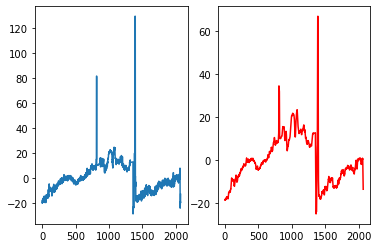

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import random

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

x = nR
y1 = running_mean(x, 10)
plt.subplot(1,2,1)
plt.plot(x)
plt.subplot(1,2,2)
plt.plot(y1,'r')

# ICA

In [209]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, X)

    return Xw, whiteM

def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

# Preprocessing

In [210]:
X = (np.c_[nR, nG, nB]).T

In [211]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

# Check if covariance of whitened matrix equals identity matrix
print(np.round(covariance(Xw)))

[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]


# Running ICA

In [212]:
W = fastIca(Xw,  alpha=1)

#Un-mix signals using
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

# Plotting Signals

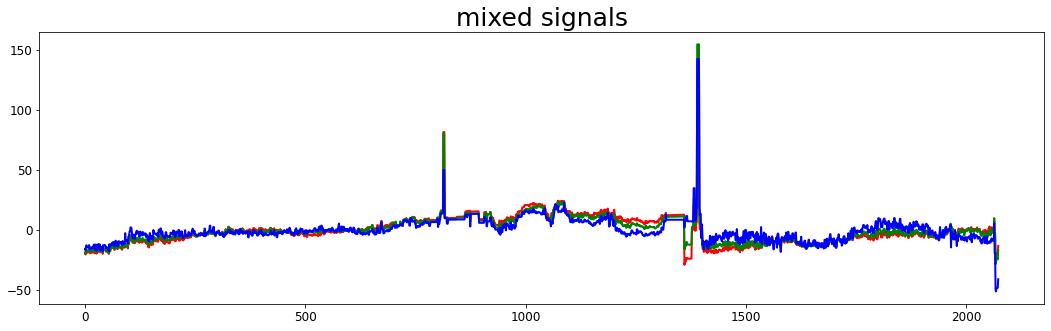

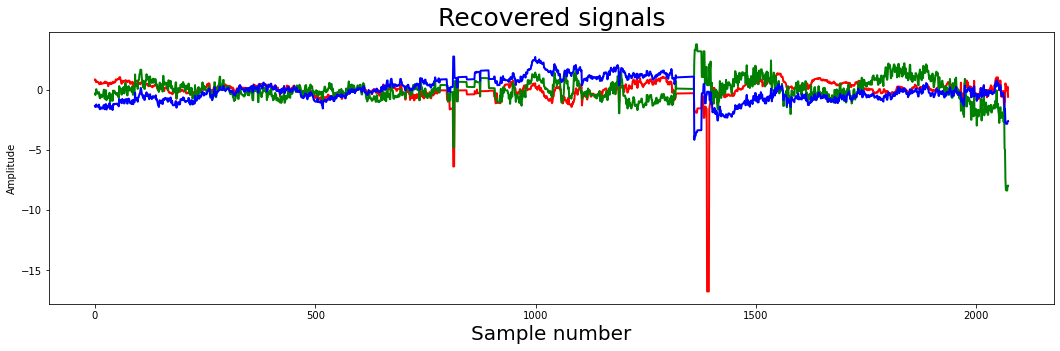

In [213]:

colors = ['red', 'green', 'blue']
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
for i in range(3):
    ax.plot(X[i], lw = 2, color = colors[i])
ax.tick_params(labelsize=12)
ax.set_title('mixed signals', fontsize=25)
# ax.set_xlim(0, 10)

fig, ax = plt.subplots(1, 1, figsize=[18, 5],)
for i in range(3):
    ax.plot(unMixed.T[i], lw = 2, color = colors[i])
ax.set_ylabel("Amplitude", fontsize = 10)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
# ax.set_xlim(0, 100)

plt.show()

# FFT

## Green

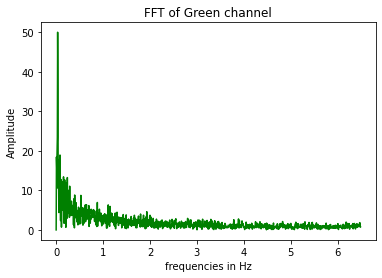

In [214]:
from scipy.fftpack import fft
# Number of samples
N = f
FPS = f//drtn
if(FPS == 0):
    FPS = 1

sig = unMixed[:,1]
xf_g = FPS * (np.arange(int(N/2))/N)
# xf = FPS * np.linspace(0,drtn,N//2)
yf = np.abs(fft(sig))
yf_g = (1/FPS)* yf[range(int(int(N)/2))]

fig, ax = plt.subplots()
ax.plot(xf_g, yf_g, color = 'green')
ax.set_xlabel("frequencies in Hz")
ax.set_ylabel("Amplitude")
ax.set_title("FFT of Green channel")
plt.show()

## Blue

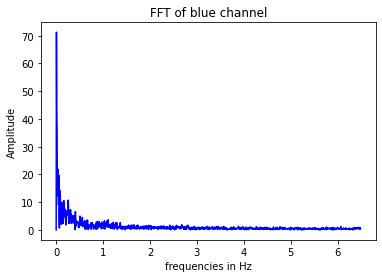

In [215]:
from scipy.fftpack import fft

# Number of samples
N = f
FPS = f//drtn
if(FPS == 0):
    FPS = 1

sig = unMixed[:,2]
xf_b = (FPS) * (np.arange(int(N/2))/N)
# xf = FPS * np.linspace(0,drtn, N//2)
yf = np.abs(fft(sig))
yf_b = (1/FPS)* yf[range(int(int(N)/2))]

fig, ax = plt.subplots()
ax.plot(xf_b, yf_b, color = 'blue')
ax.set_title("FFT of blue channel")
ax.set_xlabel("frequencies in Hz")
ax.set_ylabel("Amplitude")
plt.show()

## Red

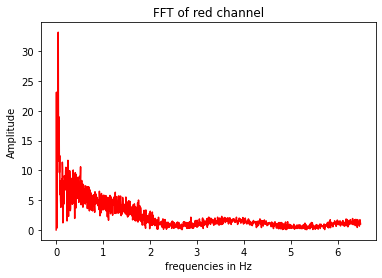

In [216]:
from scipy.fftpack import fft

# Number of samples
N = f
FPS = f//drtn
if(FPS == 0):
    FPS = 1

sig = unMixed[:,0]
xf_r = FPS * (np.arange(int(N/2))/N)
yf = np.abs(fft(sig))
yf_r = (1/FPS)* yf[range(int(int(N)/2))]

fig, ax = plt.subplots()
ax.plot(xf_r, yf_r, color = 'red')
ax.set_title("FFT of red channel")
ax.set_xlabel("frequencies in Hz")
ax.set_ylabel("Amplitude")
plt.show()

# FIR Filter

In [217]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def fir_filter(xf,yf,c):
    if __name__ == "__main__":
        import numpy as np
        import matplotlib.pyplot as plt
        from scipy.signal import freqz

#         Sample rate and desired cutoff frequencies (in Hz).
        fs = 12
        lowcut =0.1
        highcut = 5

#         Filter a noisy signal.
        f0 =highcut - lowcut
        x = yf

        y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
        ff = plt.figure()
        ff.set_figwidth(26)
        ff.set_figheight(6)
        plt.plot(xf, y,lw = 4, label='Filtered signal in Hz', color = c)
        plt.xlabel('Frequencies')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.show()
#         return x,y

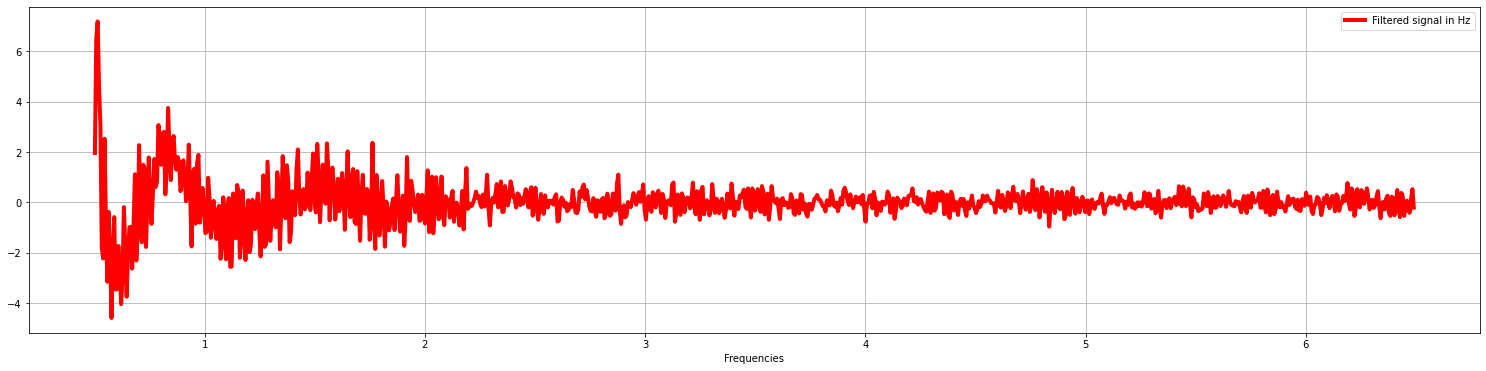

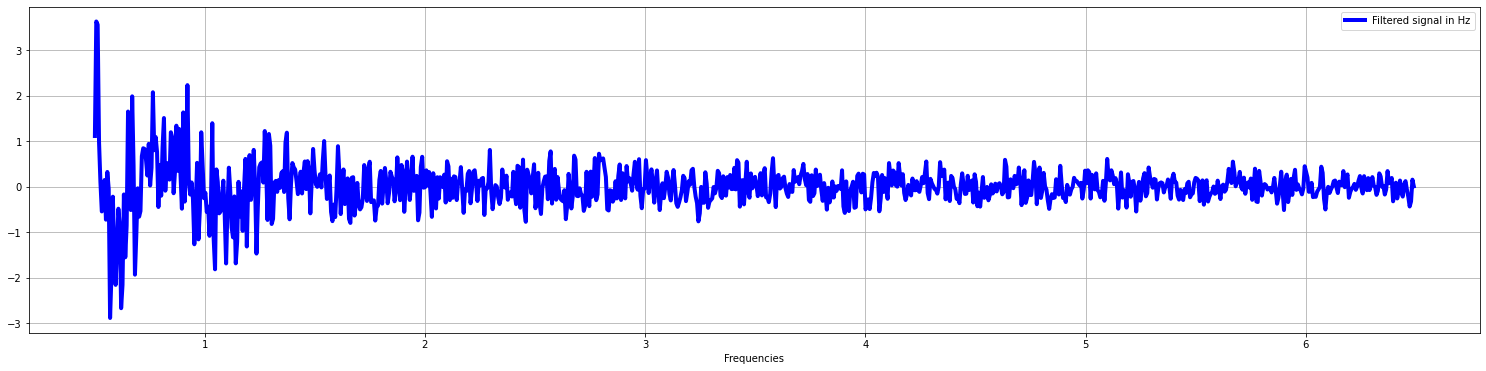

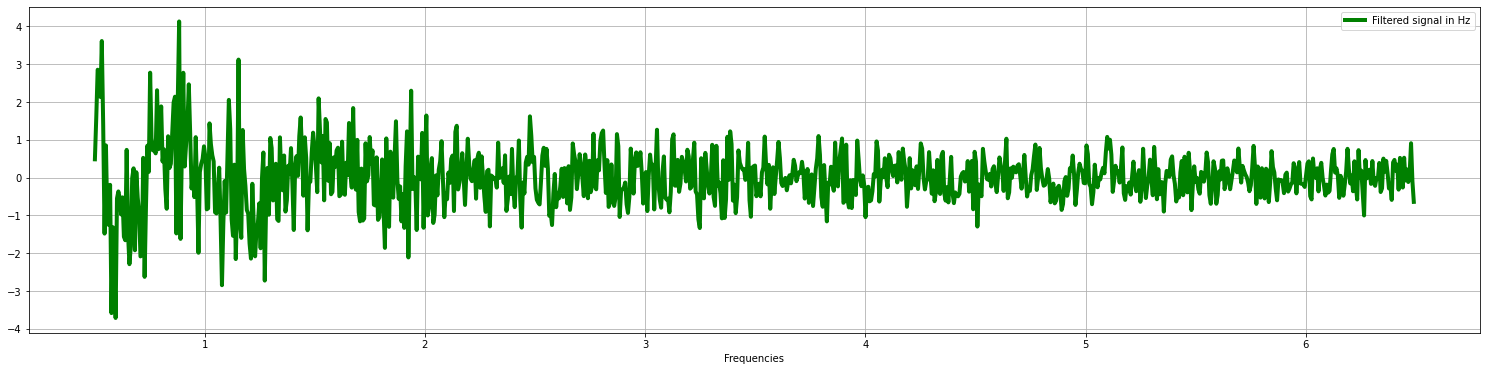

In [218]:
colors = ['red','blue','green']
ent = np.searchsorted(xf_r, 0.5)
fir_filter(xf_r[ent:],yf_r[ent:],colors[0])
fir_filter(xf_b[ent:],yf_b[ent:],colors[1])
fir_filter(xf_g[ent:],yf_g[ent:],colors[2])

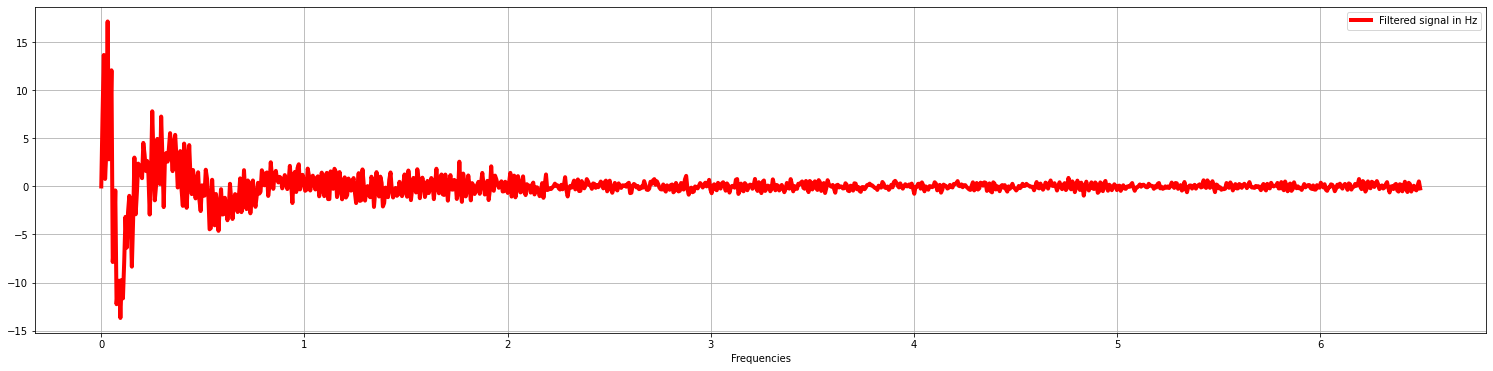

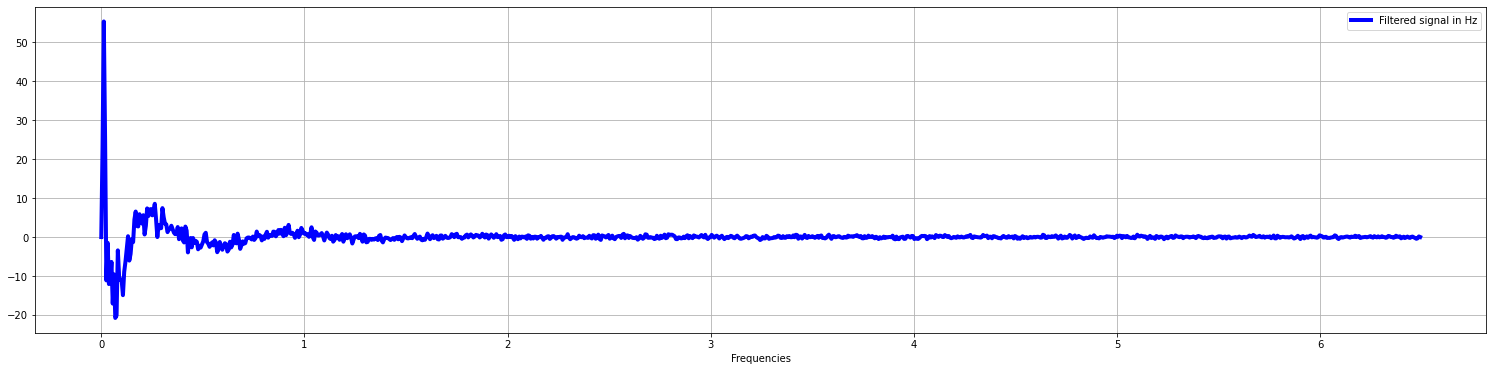

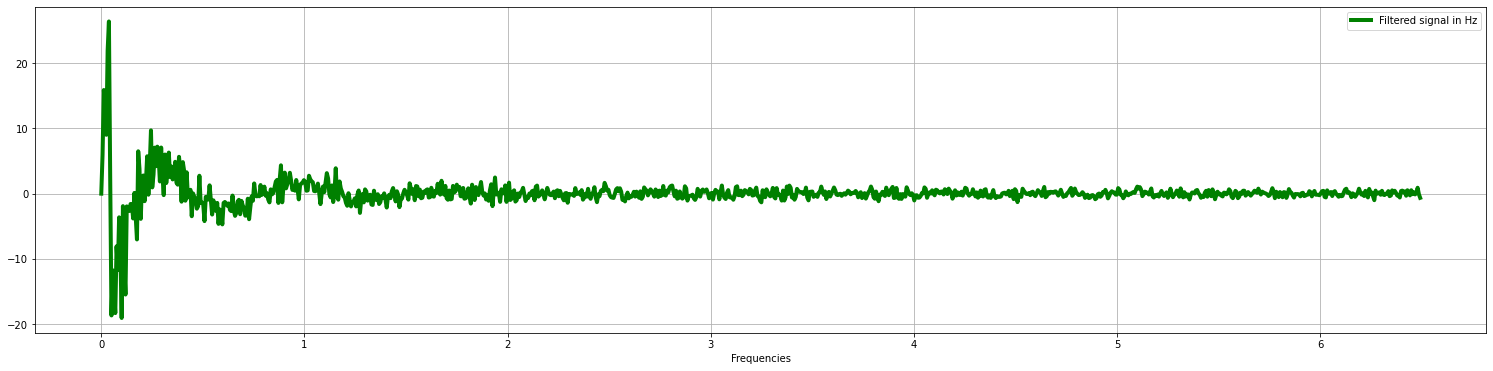

In [219]:
colors = ['red','blue','green']
fir_filter(xf_r,yf_r,colors[0])
fir_filter(xf_b,yf_b,colors[1])
fir_filter(xf_g,yf_g,colors[2])

# RR

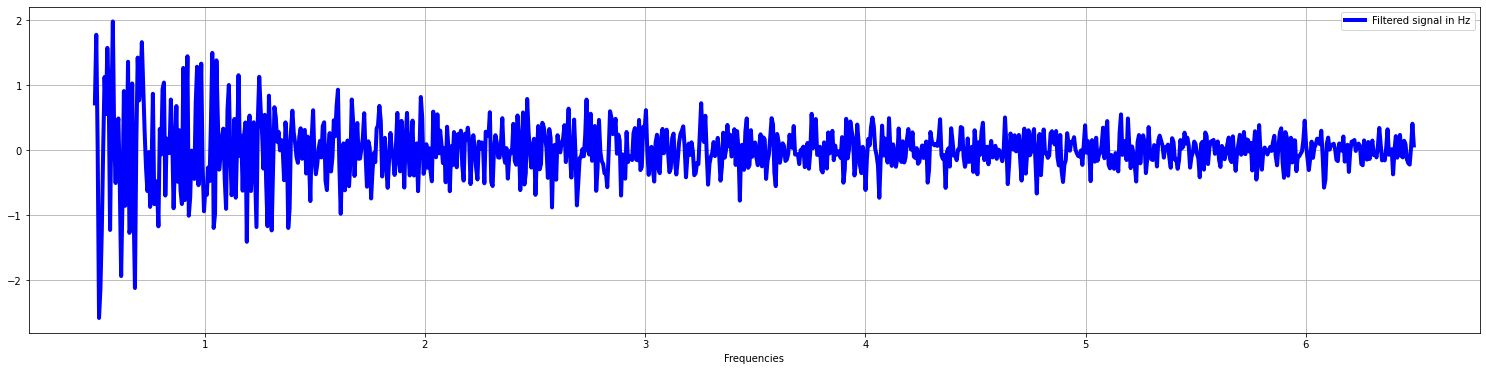

In [220]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

#         Sample rate and desired cutoff frequencies (in Hz).
    fs = 12
    lowcut =0.5
    highcut = 5

#         Filter a noisy signal.
    f0 =highcut - lowcut

    y = butter_bandpass_filter(yf_b[ent:], lowcut, highcut, fs, order=6)
    ff = plt.figure()
    ff.set_figwidth(26)
    ff.set_figheight(6)
    plt.plot(xf_b[ent:], y,lw = 4, label='Filtered signal in Hz', color = 'blue')
    plt.xlabel('Frequencies')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()


In [252]:
import pandas as pd

df = pd.read_csv('C:/Users/swast/Jupyter Codes/swastik/swastik.txt', sep = ('\t'))
df

,sec,CH1,CH2
0.000000,0.007817,0.039402,NaN
0.000133,-0.010309,1.256540,NaN
0.000267,-0.063088,4.645480,NaN
0.000400,-0.103056,6.863450,NaN
0.000533,-0.106706,6.438580,NaN
...,...,...,...
2.163330,-0.103312,-0.031302,NaN
2.163470,0.017105,-0.030979,NaN
2.163600,0.140595,-0.030979,NaN
2.163730,0.262997,-0.031302,NaN


### additional

In [222]:
# t = np.linspace(0,2.163870,16230)
# resp1 = np.array(df['CH1'])
# ppg1 = y

In [223]:
ppg1 = y
#ppg1 = np.array(df['CH1'].tolist())[:574]
resp1 = np.array(df['CH2'].tolist())[:len(ppg1)]
t = np.array(df['sec'].tolist())[:len(ppg1)]

In [224]:
from scipy import signal
import time
from PyEMD import EEMD
from vmdpy import VMD
from scipy.stats import kurtosis
from scipy.fftpack import fft, fftfreq

In [225]:
f//drtn

13

In [226]:
len(ppg1)

956

Text(0.5, 1.0, 'Filtered Signal')

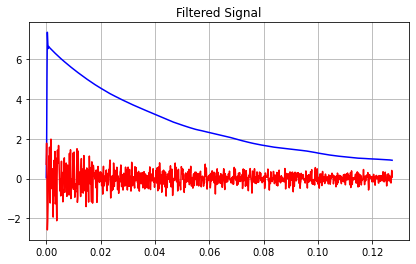

In [228]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
#plt.xlim(0.05,3)
plt.plot(t,resp1[:len(ppg1)], 'b')
plt.plot(t,ppg1, 'r')
plt.grid()
plt.title('Filtered Signal')


In [229]:
n = len(ppg1)
#f_s= f//drtn
f_s=125
freqs = fftfreq(len(resp1)) * f_s
fft_ppg = np.abs(fft(ppg1, n))
fft_resp = np.abs(fft(resp1, n))

Text(0.5, 1.0, 'Filtered Signal')

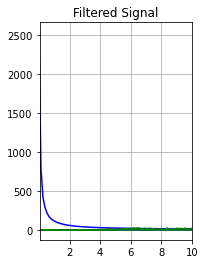

In [230]:
plt.subplot(1,2,2)
plt.plot(freqs[:len(fft_resp)], fft_resp, 'b')
plt.plot(freqs[:len(fft_ppg)], fft_ppg, 'g')
plt.xlim(0.05,10)
plt.grid()
plt.title('Filtered Signal')

In [231]:
fs = 125
sos_resp = signal.butter(4, [0.15, 0.65], 'bandpass', output='sos', fs=fs)

filt_resp = signal.sosfiltfilt(sos_resp, resp1)
N = len(ppg1)
ff_filtresp = np.abs(fft(filt_resp,N))
freqs = fftfreq(len(filt_resp)) * fs

In [232]:
peaks_index,_ = signal.find_peaks(ff_filtresp[:60])
peaks = ff_filtresp[peaks_index]
peak_freq =freqs[peaks_index]
print(f'Peaks: {peaks}')
print(f'Frequency values at peaks: {peak_freq}')

Peaks: [611.0620227]
Frequency values at peaks: [0.13075314]


In [233]:
f_s= f//drtn
sos_ppg = signal.butter(4, [0.15, 0.65], 'bandpass', output='sos', fs=f_s)
filt_ppg = signal.sosfiltfilt(sos_ppg, ppg1)
ff_filtppg = np.abs(fft(filt_ppg,N))

In [234]:
b = time.time()
eemd=EEMD()
IMFs = eemd(filt_ppg)
imfNo  = IMFs.shape[0]
print("Total Number of IMFs = " + str(imfNo))
e = time.time()
print("total time for eemd: ", (e-b))
imfs, res = IMFs[:-1], IMFs[-1]
# vis = Visualisation()
# vis.plot_imfs(imfs=imfs, residue=res, t=t[0:window_size], include_residue=True)
# vis.show()

cnt = 0

Total Number of IMFs = 10
total time for eemd:  2.5142297744750977



Index of minimum kurtosis is 8 & it's kurtosis value is -0.9191215342387267


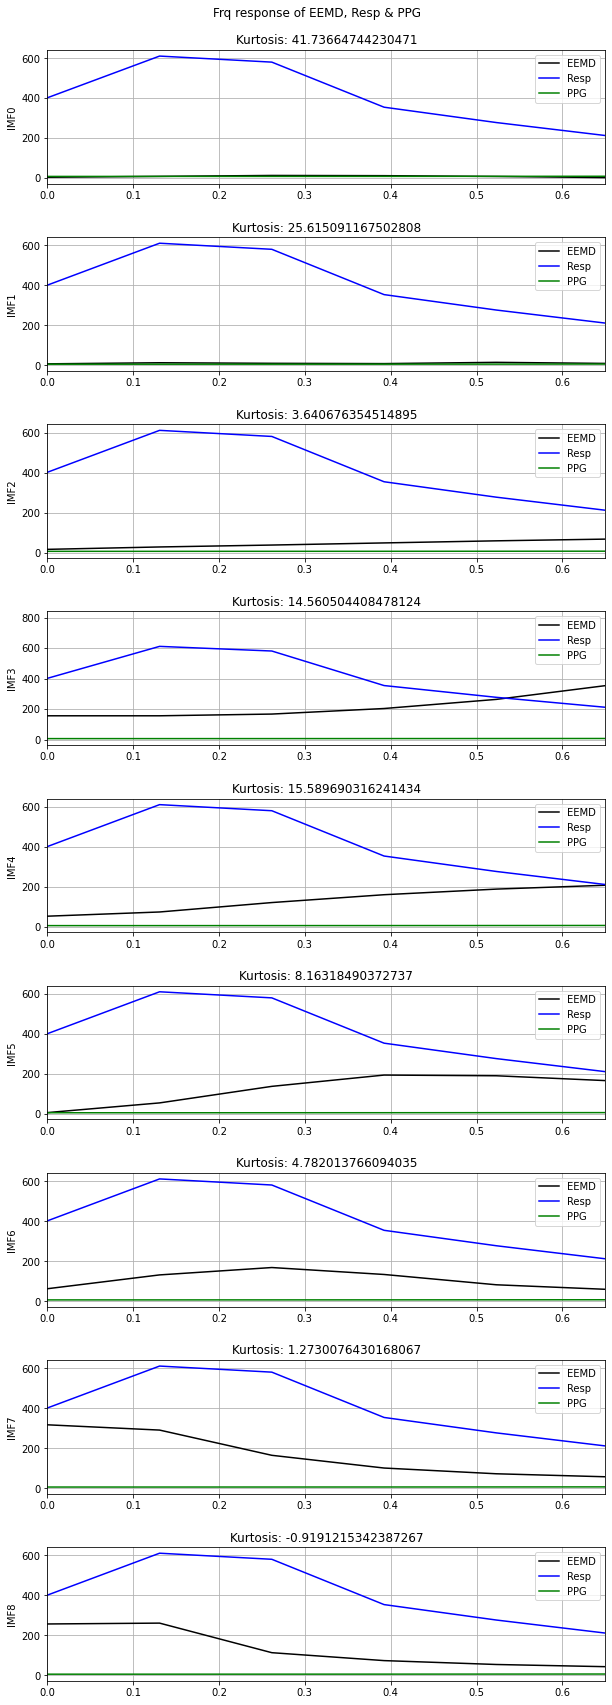

In [235]:
kurto_result_eemd = []
plt.figure(figsize=(10, 30)) 
plt.subplots_adjust(hspace=0.4)
cnt = 0
for i in imfs:
    kurto = kurtosis(i)
    kurto_result_eemd.append(kurto)
    
    plt.subplot(len(imfs), 1, cnt+1)
    plt.suptitle("Frq response of EEMD, Resp & PPG",y=0.9)
    plt.plot(freqs[0:30],100*np.abs(fft(i,N))[:30],'k')
    plt.plot(freqs[0:30],np.abs(ff_filtresp)[:30],'b')
    plt.plot(freqs[0:30],np.abs(ff_filtppg)[:30],'g')
    plt.ylabel("IMF"+str(cnt))
    plt.legend(['EEMD', 'Resp', 'PPG'], loc='best')
    plt.title(f'Kurtosis: {kurto}')
    plt.xlim(0,0.65)
    plt.grid()
    #plt.savefig(os.path.join(result, 'IMFs of EEMD.jpg'))
    cnt += 1

min_kurto_index = kurto_result_eemd.index(min(kurto_result_eemd))
print(f"\nIndex of minimum kurtosis is {min_kurto_index} & it's kurtosis value is {min(kurto_result_eemd)}")


In [236]:
Vmd_Feature_sig = imfs[8]
ff_Vmd_Feature_sig=np.abs(fft(Vmd_Feature_sig,N))

peaks_index,_ = signal.find_peaks(ff_Vmd_Feature_sig[0:60])
peaks = ff_Vmd_Feature_sig[peaks_index]
max_peak_RR = max(peaks)
index = np.where(peaks==max_peak_RR)
max_peak_index = peaks_index[index]

# find freqs from resp1 signal
freqs = fftfreq(len(resp1)) * fs
RR_freq=freqs[max_peak_index]
print("RR frequency is = "+str(RR_freq) +"Hz   and energy is = "+str(max_peak_RR) )

RR frequency is = [0.13075314]Hz   and energy is = 2.6150729587777186


In [237]:
f_s

13

In [238]:
eemd=EEMD()
IMFs = eemd(ppg1)
imfNo  = IMFs.shape[0]
print("Total Number of IMFs = " + str(imfNo))
imfs, res = IMFs[:-1], IMFs[-1]

Total Number of IMFs = 9



Index of minimum kurtosis is 6 & it's kurtosis value is -0.3580436525641879


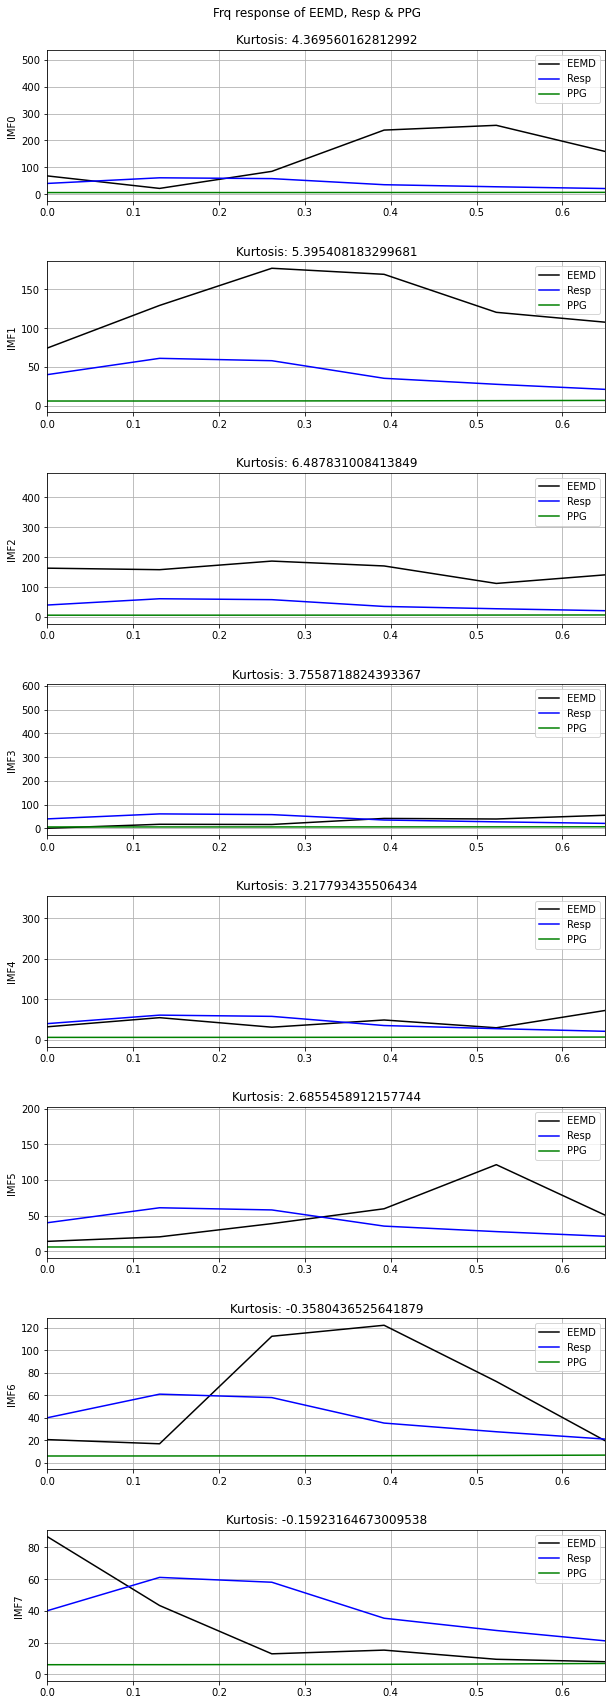

In [239]:
kurto_result_eemd = []
plt.figure(figsize=(10, 30)) 
plt.subplots_adjust(hspace=0.4)
cnt = 0
for i in imfs:
    kurto = kurtosis(i)
    kurto_result_eemd.append(kurto)
    
    plt.subplot(len(imfs), 1, cnt+1)
    plt.suptitle("Frq response of EEMD, Resp & PPG",y=0.9)
    plt.plot(freqs[0:30],100*np.abs(fft(i,N))[:30],'k')
    plt.plot(freqs[0:30],0.1*np.abs(ff_filtresp)[:30],'b')
    plt.plot(freqs[0:30],np.abs(ff_filtppg)[:30],'g')
    plt.ylabel("IMF"+str(cnt))
    plt.legend(['EEMD', 'Resp', 'PPG'], loc='best')
    plt.title(f'Kurtosis: {kurto}')
    plt.xlim(0,0.65)
    plt.grid()
    #plt.savefig(os.path.join(result, 'IMFs of EEMD.jpg'))
    cnt += 1

min_kurto_index = kurto_result_eemd.index(min(kurto_result_eemd))
print(f"\nIndex of minimum kurtosis is {min_kurto_index} & it's kurtosis value is {min(kurto_result_eemd)}")

In [240]:
HR_sig=IMFs[4];
ff_HR=np.abs(fft(HR_sig,N))*5

peaks_index,_= signal.find_peaks(ff_HR[0:160])
peaks=ff_HR[peaks_index]
max_peak=max(peaks)
index=np.where(peaks==max_peak)
max_peak_index=peaks_index[index]
HR_freq=freqs[max_peak_index]

HR frequency is =[1.83054393]Hz


C:\Users\swast\AppData\Local\Temp/ipykernel_2864/995704368.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(HR_freq,max_peak,'ro',MarkerSize=10)


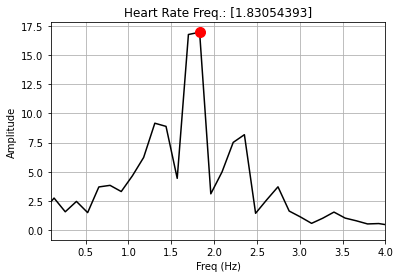

In [241]:
plt.plot(freqs[0:160],ff_HR[0:160],'k')
plt.plot(HR_freq,max_peak,'ro',MarkerSize=10)
plt.xlabel('Freq (Hz)')
plt.xlim(0.09,4)
# plt.ylim(0,700)
plt.ylabel('Amplitude')
plt.grid()
plt.title(f'Heart Rate Freq.: {HR_freq}')
#plt.savefig(os.path.join(result,'Heart_rate.jpg'))

print("HR frequency is ="+str(HR_freq) +"Hz")

In [242]:
sos_narrow= signal.butter(4, [HR_freq-0.6, HR_freq+0.6], 'bandpass', output='sos', fs=f_s)

In [243]:
N

956

Text(0.5, 1.0, 'FFT Resampled AM peaks= RIAV (Traditional) ')

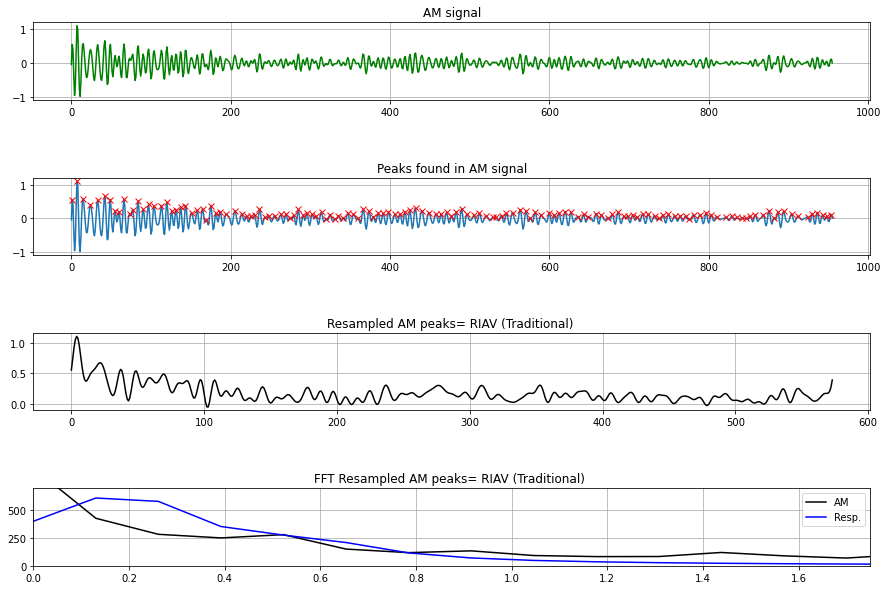

In [244]:
plt.figure(figsize=(15, 10)) 
plt.subplots_adjust(hspace=1)

AM_sig= signal.sosfiltfilt(sos_narrow, ppg1)
plt.subplot(4,1,1)
plt.plot(AM_sig,'g')
plt.grid()
plt.title("AM signal")

#upper envelope
AM_peaks_index,_ = signal.find_peaks(AM_sig);
AM_peaks=AM_sig[AM_peaks_index];
plt.subplot(4,1,2)
plt.plot(AM_sig)
plt.plot(AM_peaks_index,AM_peaks,'rx')
plt.grid()
plt.title("Peaks found in AM signal")

#--------------------------------------------------------------
#Resample the reduced samples of upper envelope peaks==>>> RIAV
#--------------------------------------------------------------
Resampled_AM=signal.resample(AM_peaks[0:len(AM_peaks)-3],574)
ff_resample_am=np.abs(fft(Resampled_AM,N))
plt.subplot(4,1,3)
plt.plot(Resampled_AM,'k') ;
plt.grid()
plt.title("Resampled AM peaks= RIAV (Traditional) ")

plt.subplot(4,1,4)
plt.plot(freqs[0:60],9*ff_resample_am[0:60],'k') ;
plt.plot(freqs[0:60],np.abs(ff_filtresp[0:60]),'b')
plt.xlim(0.0,1.75)
plt.ylim(0,700)
plt.grid()
plt.legend(['AM', 'Resp.'])
plt.title("FFT Resampled AM peaks= RIAV (Traditional) ")

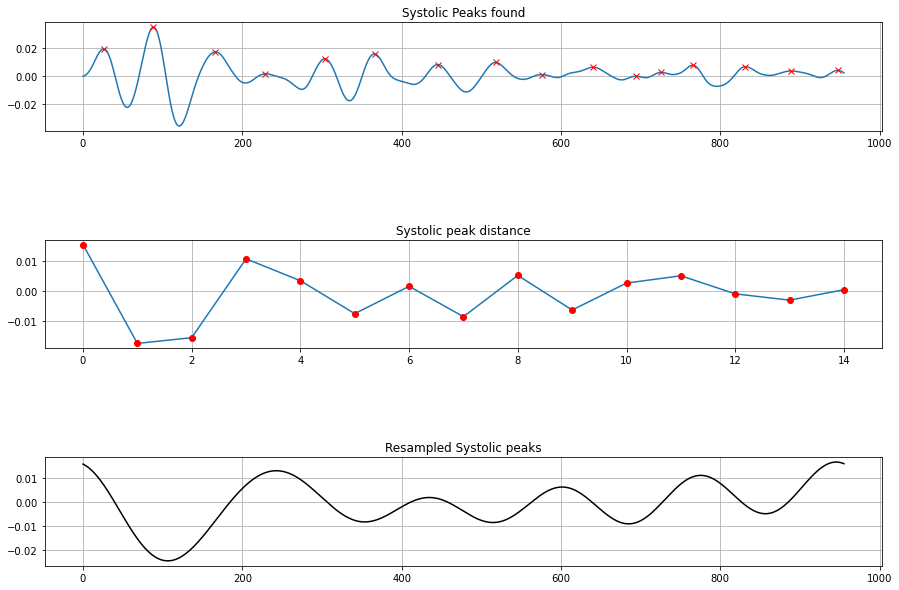

In [245]:
p=np.max(ppg1)
q=np.min(ppg1)
HR_sig=IMFs[4]

#upper envelope
up_peaks_location,_ = signal.find_peaks(HR_sig);
up_peaks=HR_sig[up_peaks_location];

Rpeak_dist=np.zeros((len(up_peaks)-1, 1))
for i in range (len(up_peaks)-1) :
   Rpeak_dist[i,:]=up_peaks[i+1]-up_peaks[i]


RIFV=signal.resample(Rpeak_dist[0:len(Rpeak_dist)-2],N)
RIFV=np.array(RIFV)

plt.figure(figsize=(15, 10)) 
plt.subplots_adjust(hspace=1)

plt.subplot(3,1,1)
plt.plot(HR_sig)
plt.plot(up_peaks_location,up_peaks,'rx')
plt.grid()
plt.title("Systolic Peaks found")

plt.subplot(3,1,2)
plt.plot(Rpeak_dist)
plt.plot(Rpeak_dist,'ro')
plt.grid()
plt.title("Systolic peak distance")

plt.subplot(3,1,3)
plt.plot(RIFV,'k') ;
plt.title('Resampled Systolic peaks') 
plt.grid()

(0.0, 2.0)

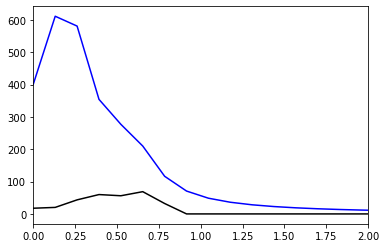

In [246]:
rifv=RIFV.reshape(N,)
ff_rifv=np.abs(fft(rifv,N))
plt.plot(freqs[0:100],np.abs(ff_filtresp[0:100]),'b')
plt.plot(freqs[0:100],19*ff_rifv[0:100],'k')
plt.xlim(0.00,2)


Index of minimum kurtosis is 1 & it's kurtosis value is -1.5040645720034629


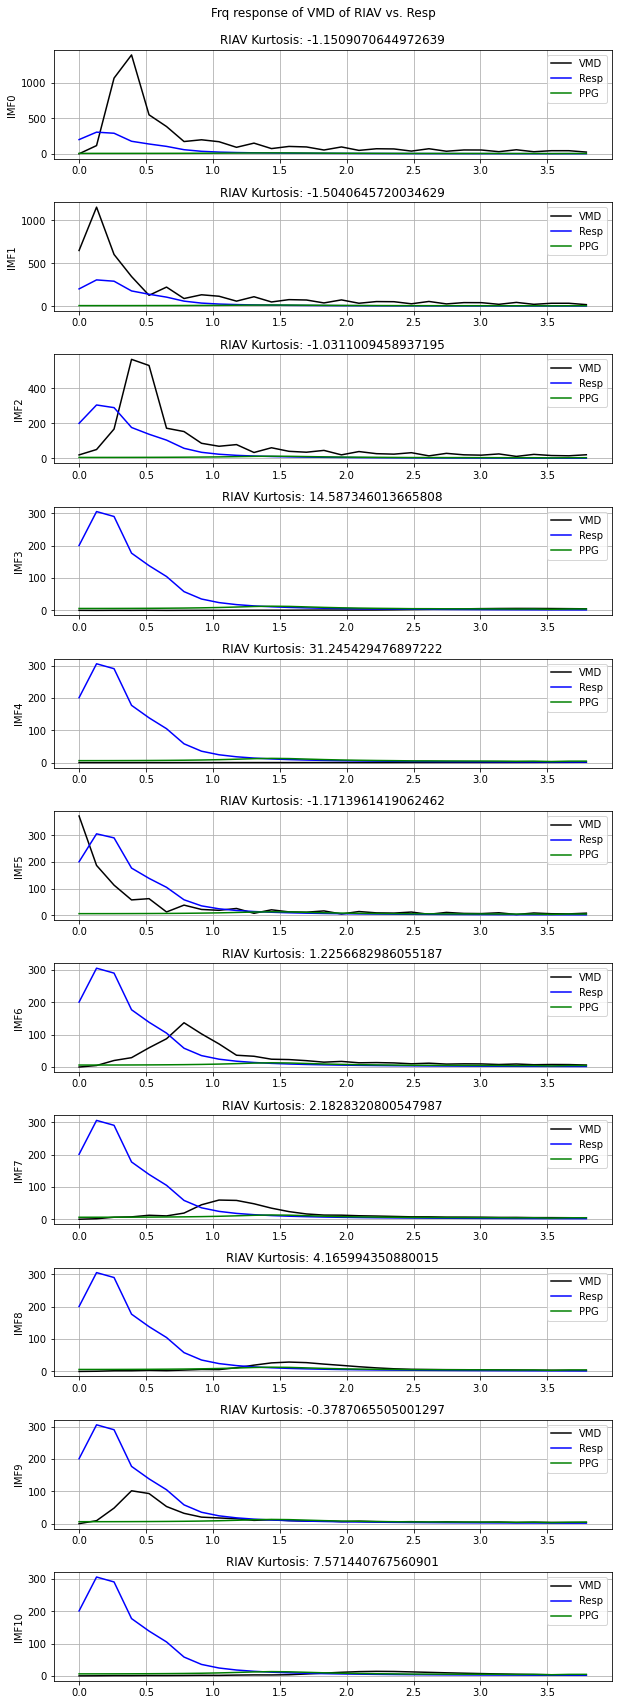

In [247]:
riav_resp_filt=signal.sosfiltfilt(sos_resp, Resampled_AM)
K = 11
alpha = 2500       # moderate bandwidth constraint  
tau = 0            # noise-tolerance (no strict fidelity enforcement)               # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7         # tolerance

u_riav, u_riav_hat, omega = VMD(riav_resp_filt, alpha, tau, K, DC, init, tol)  

cnt= 0
plt.figure(figsize=(10, 30)) 
plt.subplots_adjust(hspace=0.4)

modes_riav = u_riav

kurto_result_riav = []

for i in modes_riav :
    kurto = kurtosis(i)
    kurto_result_riav.append(kurto)
    
    plt.subplot(len(modes_riav),1,cnt+1)
    plt.plot(freqs[0:30],100*np.abs(fft(i,N))[:30],'k')
    plt.plot(freqs[0:30],0.5*np.abs(ff_filtresp)[:30],'b')
    plt.plot(freqs[0:30],np.abs(ff_filtppg)[:30],'g')
    plt.ylabel("IMF"+str(cnt))
    plt.suptitle("Frq response of VMD of RIAV vs. Resp",y=0.9)
    plt.legend(['VMD', 'Resp', 'PPG'], loc='best')
    plt.title(f'RIAV Kurtosis: {kurto}')
    plt.grid()
    cnt=cnt+1
    #plt.savefig(os.path.join(result, f'RIAV.jpg'))
    
min_kurto_index = kurto_result_riav.index(min(kurto_result_riav))
print(f"\nIndex of minimum kurtosis is {min_kurto_index} & it's kurtosis value is {min(kurto_result_riav)}")

In [250]:
dominant_peak_sig = modes_riav[1]
dominant_peak_sig_fft = np.abs(fft(dominant_peak_sig, N))
peaks_index,_= signal.find_peaks(dominant_peak_sig_fft[0:60])
peaks=dominant_peak_sig_fft[peaks_index]
max_peak=max(peaks)
index=np.where(peaks==max_peak)
max_peak_index=peaks_index[index]
RR_freq=freqs[max_peak_index]

In [251]:
RR_freq

array([0.13075314])